# Passing RTL-SDR data through setigen's voltage backend

Before running this notebook, make sure you have collected data using the `observe.sh` script. An example script command is in `example_observation.sh`. For this tutorial, we had the RTL-SDR dongle collect 60 s of data at a center frequency of 90.3 MHz (a local FM station) at a sampling rate of 2.048 MHz, into a file `rtlsdr.dat`.

First, we enable GPU usage for `setigen` and set the used device to the first GPU.

In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

if os.environ['SETIGEN_ENABLE_GPU'] == '1':
    try:
        import cupy as xp
    except ImportError:
        import numpy as xp
else:
    import numpy as xp

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, '/home/bryanb/setigen')
import setigen as stg

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

The `setigen` voltage backend assumes that input voltages will typically be real. So, the sample rate required by `setigen` is actually twice the sample rate used by RTL-SDR dongles to collect IQ data. 

Since the carrier frequency (90.3 MHz in this case) is the center of the unique IQ frequency range, the starting frequency for real sampling is `fch1 = carrier_freq - iq_sample_rate / 2`. 

For more info on real vs. IQ voltage sampling, see: http://people.cst.cmich.edu/yelam1k/asee/proceedings/2019/1/92.pdf.

In [4]:
iq_sample_rate = 2.048e6
sample_rate = iq_sample_rate * 2
carrier_freq = 90.3e6

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=carrier_freq - iq_sample_rate / 2,
                              ascending=True,
                              num_pols=1)

### Loading IQ data

The data collected by the `rtl_sdr` utility are saved in bytes representing unsigned 8-bit integers, one for each I and Q component. Again, IQ data is sampled at half the rate required to obtain the same unique frequency spectrum as *real* sampling. So, we have to be a little creative when loading IQ data, since we're essentially combining the two types of input voltage data. 

To that end, we can load in IQ data as complex voltages sampled at the IQ sampling rate, essentially populating every other sample. Then, instead of using the `RealQuantizer` as the digitizer as usual, we can actually use the `ComplexQuantizer`. 

In [5]:
num_taps = 8
num_branches = 64

digitizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                         num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

start_chan = 0
num_chans = num_branches // 2
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=start_chan,
                                    num_chans=num_chans,
                                    block_size=33554432,
                                    blocks_per_file=128,
                                    num_subblocks=32)

Now, we create the custom signal injection function using the saved IQ data. Normally, the voltage backend retrieves `num_samples` real voltage samples iteratively. This corresponds to `num_samples / 2` IQ sample pairs, hence we only populate every other index of the signal with complex IQ data. The last part to keep in mind is that IQ data is centered at 0 (i.e. by mixing down from the center / carrier frequency), so we have to shift the response up to `f = iq_sample_rate / 2` to match the unique frequency range of a real-sampled signal at sample rate `iq_sample_rate * 2`. For completeness, `setigen` specifically records (at most) the Nyquist bandwidth from 0 to `sample_rate / 2 = iq_sample_rate`, so we have to make sure the frequency responses match this. 

In [6]:
f = open('rtlsdr.dat', 'rb')

def iq_signal(f):
    """f is the file handler"""
    def sub_func(ts):
        num_samples = len(ts)

        iq = f.read(num_samples)

        iq = xp.array(np.frombuffer(iq, dtype=np.uint8), dtype='float')
        iq -= 128
        iq = iq[0::2] + iq[1::2] * 1j

        # IQ bandwidth is iq_sample_rate, so shift by half
        shift_freq = iq_sample_rate / 2
        iq_shifted = iq * xp.exp(1j * 2 * xp.pi * shift_freq * ts[0::2])

        v = xp.zeros(num_samples, dtype='complex')
        v[0::2] = iq_shifted
        return v
    return sub_func

antenna.x.add_signal(iq_signal(f))

## Recording synthetic data
We can now record the data in GUPPI RAW format. In this example, the recording has about 60 seconds of data.

In [7]:
rvb.record(raw_file_stem='rtlsdr',
           obs_length=60, 
           length_mode='obs_length',
           header_dict={},
           verbose=False)

f.close()

Blocks: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]     


## Taking a look
If `rawspec` is installed, you can unpack the data as such:

In [8]:
!rawspec -f 1024 -t 1 rtlsdr

working stem: rtlsdr
opening file: rtlsdr.0000.raw
opening file: rtlsdr.0001.raw [No such file or directory]
output product 0: 3584 spectra


Using `blimpy` to open the resulting filterbank file and plotting the data:

/datax/scratch/bbrzycki/miniconda3/envs/bl_tf/lib/python3.8/site-packages/blimpy/utils.py:10: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


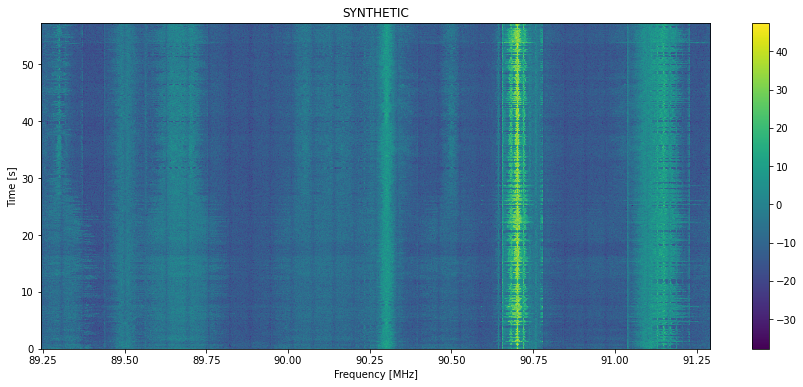

Dimensions (df, dt): (62.5 Hz, 0.016 s)


In [9]:
frame = stg.Frame('rtlsdr.rawspec.0000.fil')

plt.figure(figsize=(15, 6))
frame.bl_render()
plt.show()

print(f'Dimensions (df, dt): ({frame.df} Hz, {frame.dt} s)')

Integrating over time, and marking the boundaries of the coarse channels:

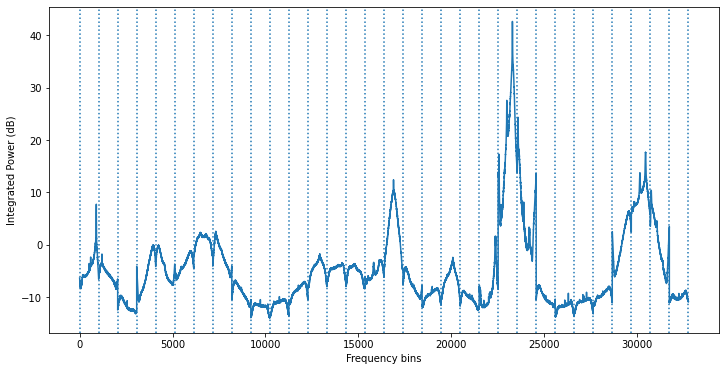

In [10]:
x = stg.db(frame.data.mean(axis=0))

plt.figure(figsize=(12, 6))
plt.plot(x)
for i in range(num_branches // 2 + 1):
    plt.axvline(i * frame.fchans / (num_branches // 2), ls=':')
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

Using more branches in the PFB FFT results in more, smaller coarse channels. Since we're looking at FM signals with a relatively large (overall) frequency bandwidth compared to SETI narrowband signals, smaller coarse channels can reduce sensitivity to these wider signals and introduce artifacts at the edges, as seen in the plot above.

One last effect in this process to be aware of is that since the voltage pipeline specifically uses a PFB, and since we typically ingest real voltages, the first coarse channel (i.e. index 0) normally is symmetric around the center, whose frequency corresponds to `fch1` in `Antenna`. Furthermore, the voltage pipeline keeps this 0th PFB FFT bin and drops the (n/2+1)'th one to ensure we come out with an even `num_branches // 2` coarse channels at the end. For real voltages, this basically means we lose out on a half channel at the end of the frequency range, in favor of a reflected half channel in the 0th bin. 

When we inject complex voltages as IQ data, we make sure that the frequency ranges perfectly overlap. Since it's a complex FFT, there are no reflected half bins; the full frequency range is unique. However, this means that in the normally reflected half channel in bin 0, there will be some kind of spectral content from the IQ range (i.e. since we are missing the half bin at the end). The frequency content of IQ data repeats outside the unique range like translations (as opposed to real voltage FFTs, which alias as reflections over half the sampling rate), so the frequency content that would show up in the last half bin of the FFT instead shows up in the *first* half bin. So, the content is still there, but the frequencies will be misleading. 

Once again, this is an effect of the PFB pipeline, but is only most obvious when using a small number of branches for the PFB FFT. Here's an example with 4 branches, so that there are only 2 coarse channels. 

In [11]:
num_taps = 8
num_branches = 4

digitizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                         num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=32,
                                           num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=carrier_freq - iq_sample_rate / 2,
                              ascending=True,
                              num_pols=1)

start_chan = 0
num_chans = num_branches // 2
rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=start_chan,
                                    num_chans=num_chans,
                                    block_size=33554432,
                                    blocks_per_file=128,
                                    num_subblocks=32)

f = open('rtlsdr.dat', 'rb')

antenna.x.add_signal(iq_signal(f))

rvb.record(raw_file_stem='rtlsdr',
           obs_length=60, 
           length_mode='obs_length',
           header_dict={},
           verbose=False)

f.close()

Blocks: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]     


In [12]:
!rawspec -f 1024 -t 1 rtlsdr

working stem: rtlsdr
opening file: rtlsdr.0000.raw
opening file: rtlsdr.0001.raw [No such file or directory]
output product 0: 57344 spectra


/datax/scratch/bbrzycki/miniconda3/envs/bl_tf/lib/python3.8/site-packages/blimpy/utils.py:10: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


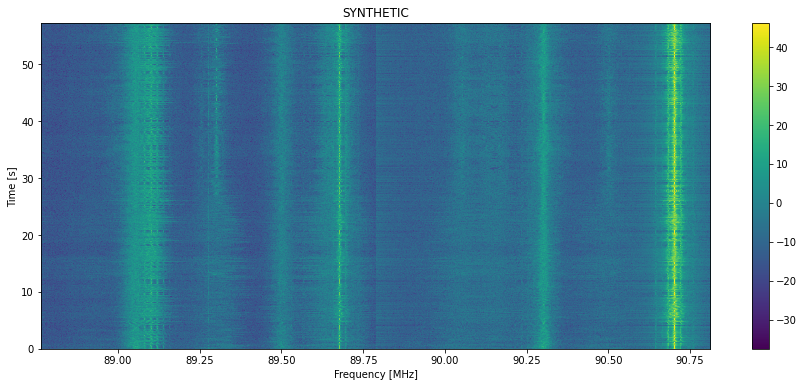

Dimensions (df, dt): (1000.0 Hz, 0.001 s)


In [13]:
frame = stg.Frame('rtlsdr.rawspec.0000.fil')

plt.figure(figsize=(15, 6))
frame.bl_render()
plt.show()

print(f'Dimensions (df, dt): ({frame.df} Hz, {frame.dt} s)')

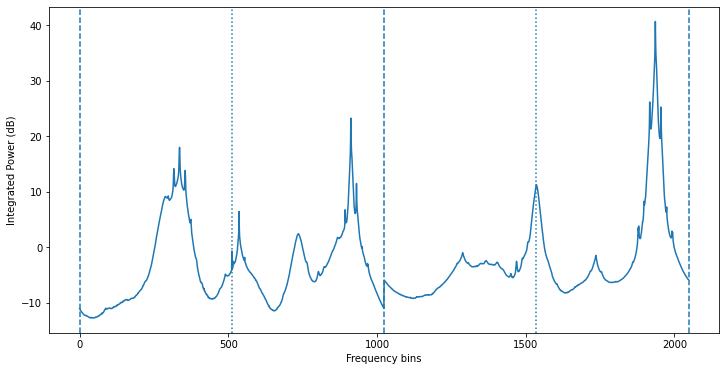

In [14]:
x = stg.db(frame.data.mean(axis=0))

plt.figure(figsize=(12, 6))
plt.plot(x)
for i in range(num_branches // 2 + 1):
    plt.axvline(i * frame.fchans / (num_branches // 2), ls='--')
for i in range(num_branches // 2):
    plt.axvline((i + 0.5) * frame.fchans / (num_branches // 2), ls=':')
plt.xlabel('Frequency bins')
plt.ylabel('Integrated Power (dB)')
plt.show()

Sure enough, if you imagine moving the first half bin to the end, the spectrum looks almost identical to the earlier spectrum with 64 branches, save for the coarse channel edge artifacts! As with pure real voltage inputs, this is all to say that you can only truly trust frequencies starting from `fch1`, or the middle of the 0th FFT bin, onwards. 